In [107]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [108]:
import os
import numpy as np
import tqdm
import time
import pathlib

import tensorflow as tf

from scrinet.fits.nn import RegressionANN

In [109]:
import schwimmbad
import functools
import tqdm

In [110]:
# import sys
# sys.path.append("/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline")
from pipe_utils import init_logger, load_data

In [111]:
from evaluate_model import match, wave_sur_many, load_model

In [112]:
import generators

In [113]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
def upsample(x, y, npts=None):
    new_x = np.linspace(x[0], x[-1], npts)
    iy = IUS(x, y)
    return new_x, iy(new_x)

def resample(x, y, new_x):
    iy = IUS(x, y)
    return new_x, iy(new_x)

In [114]:
def wave_sur_many(qs, chi1z, chi2z, amp_model, amp_basis, phase_model, phase_basis, times=None):
    
    default_times = np.linspace(-10000, 100, 5000)
    if times is not None:
        #resample basis
        new_amp_basis = np.zeros(shape=(amp_basis.shape[0], len(times)))
        for i in range(amp_basis.shape[0]):
            _, new_amp_basis[i] = resample(default_times, amp_basis[i], times)
        amp_basis = new_amp_basis
            
        new_phase_basis = np.zeros(shape=(phase_basis.shape[0], len(times)))
        for i in range(phase_basis.shape[0]):
            _, new_phase_basis[i] = resample(default_times, phase_basis[i], times)
        phase_basis = new_phase_basis
    else:
        times = default_times
    
    pars = np.array(list(zip(qs, chi1z, chi2z)))
    pars[:,0] = np.log(pars[:,0]) # need to log the mass-ratio

    amp_alpha = amp_model.predict(pars)
    amp = np.dot(amp_alpha, amp_basis)

    phase_alpha = phase_model.predict(pars)
    phase = np.dot(phase_alpha, phase_basis)

    h = amp * np.exp(-1.j * phase)

    return np.real(h), np.imag(h), amp, phase, times

In [115]:
pwd

'/nfshome/store01/users/sebastian.khan/git/stk/scrinet/bin/dev/pipeline'

In [116]:
# rootdir = '/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline/test-run/run'
rootdir = '/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline/test-run-3d/run'

In [117]:
amp_basis = os.path.join(rootdir, 'rb/amp/amp_eim_basis.npy')
amp_model_dir = os.path.join(rootdir, 'ts/amp/fits')

phase_basis = os.path.join(rootdir, 'rb/phase/phase_eim_basis.npy')
phase_model_dir = os.path.join(rootdir, 'ts/phase/fits')

In [118]:
amp_model, amp_basis = load_model(
    basis_file=amp_basis,
    nn_weights_file=os.path.join(amp_model_dir, "best.h5"),
    X_scalers_file=os.path.join(amp_model_dir, "X_scalers.npy"),
    Y_scalers_file=os.path.join(amp_model_dir, "Y_scalers.npy"))

phase_model, phase_basis = load_model(
    basis_file=phase_basis,
    nn_weights_file=os.path.join(phase_model_dir, "best.h5"),
    X_scalers_file=os.path.join(phase_model_dir, "X_scalers.npy"),
    Y_scalers_file=os.path.join(phase_model_dir, "Y_scalers.npy"))

In [119]:
qs = [2]
chi1zs = [0.90]
chi2zs = [0.4]

In [120]:
# %%timeit
ts_times, ts_amp, ts_phase, ts_freq, coords = \
    generators.gen_3d_non_prec_data(qs, chi1zs, chi2zs, 60, 1, deltaT=1./1024., npts=5000*10)
ts_hp = np.real(ts_amp * np.exp(-1.j * ts_phase))

In [121]:
ts_hp.shape

(1, 50000)

In [122]:
# %%timeit
sur_hp, sur_hc, samp, sphase, sur_times = wave_sur_many(coords[:,0], coords[:,1], coords[:,2], amp_model, amp_basis, phase_model, phase_basis, ts_times)

In [123]:
sur_hp.shape

(1, 50000)

In [124]:
ts_times.shape

(50000,)

In [125]:
sur_times.shape

(50000,)

(-100, 100)

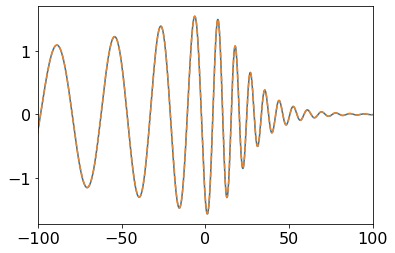

In [126]:
plt.figure()
plt.plot(ts_times, ts_hp[0])
plt.plot(ts_times, sur_hp[0], ls='--')
plt.xlim(-100,100)

In [127]:
mask = ts_times > -1000
maxmatch = np.max(np.abs(match(ts_hp[0][mask], sur_hp[0][mask], ts_times[mask])))
print(maxmatch)

0.9998902313857064


In [128]:
maxmatch = np.max(np.abs(match(ts_hp[0], sur_hp[0], ts_times)))
print(maxmatch)

0.9999522565693229


(-1000, 100)

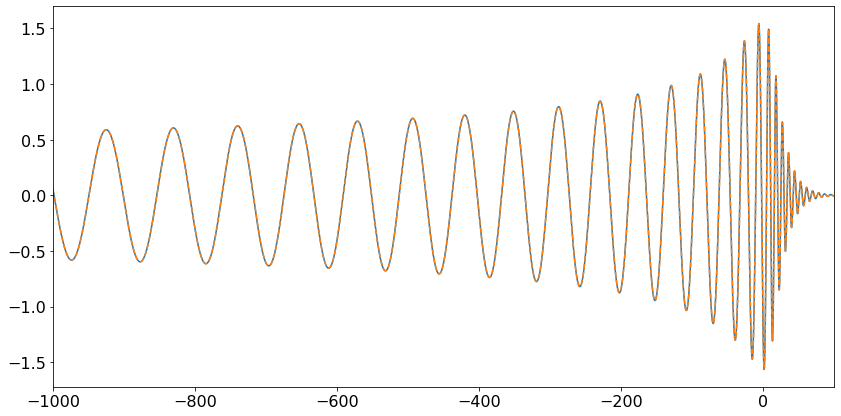

In [129]:
plt.figure(figsize=(14, 7))
plt.plot(ts_times, ts_hp[0])
plt.plot(ts_times, sur_hp[0], ls='--')
plt.xlim(-1000,100)

(-100, 100)

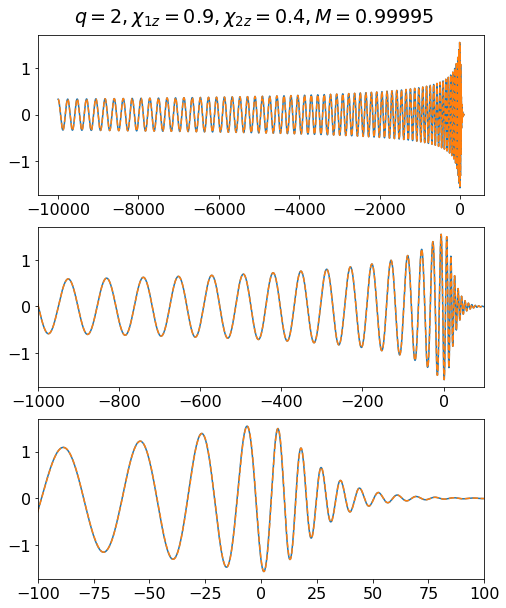

In [130]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
fig.suptitle(fr"$q = {qs[0]}, \chi_{{1z}} = {chi1zs[0]}, \chi_{{2z}} = {chi2zs[0]}, M = {maxmatch:.5f}$", y=0.92)
for ax in axes:
    ax.plot(ts_times, ts_hp[0])
    ax.plot(ts_times, sur_hp[0], ls='--')
axes[1].set_xlim(-1000,100)
axes[2].set_xlim(-100,100)
# plt.xlim(-1000,100)
# plt.title(fr"q = {qs[0]}, \chi = {chis[0]}")

(-100, 100)

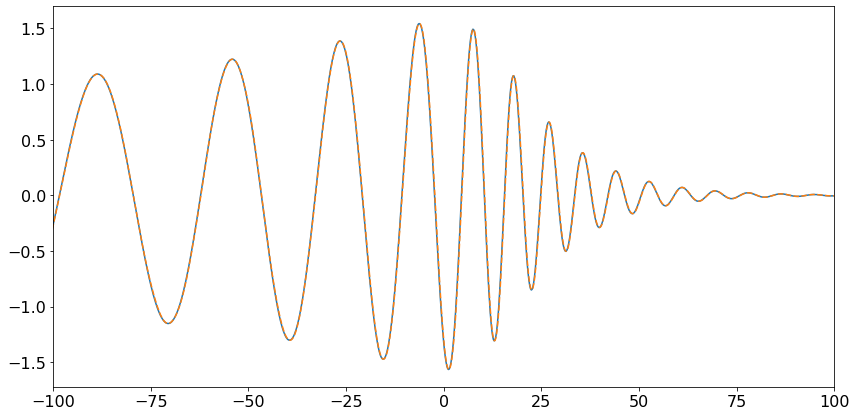

In [131]:
plt.figure(figsize=(14, 7))
plt.plot(ts_times, ts_hp[0])
plt.plot(ts_times, sur_hp[0], ls='--')
plt.xlim(-100,100)
# plt.xlim(-1000,100)

(-100, 100)

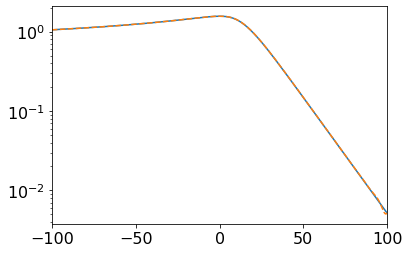

In [132]:
plt.figure()
plt.plot(ts_times, ts_amp[0])
plt.plot(ts_times, samp[0], ls='--')
plt.yscale('log')
plt.xlim(-100,100)

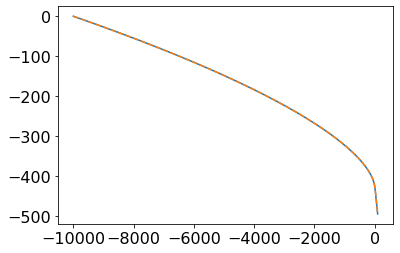

In [133]:
plt.figure()
plt.plot(ts_times, ts_phase[0])
plt.plot(ts_times, sphase[0], ls='--')
# plt.xlim(-100,100)

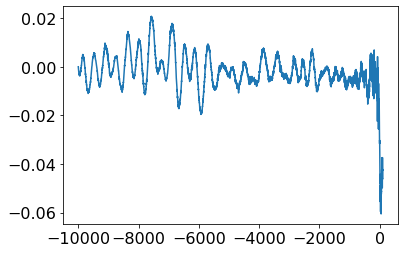

In [134]:
plt.figure()
plt.plot(ts_times, ts_phase[0]-sphase[0])
# plt.xlim(-100,100)

# grid up approach

In [36]:
# make true signal

q_true = [3]
chi1z_true = [0.345]
chi2z_true = [-0.345]

true_ts_times, true_ts_amp, true_ts_phase, true_ts_freq, true_coords = \
    generators.gen_3d_non_prec_data(q_true, chi1z_true, chi2z_true, 60, 1, deltaT=1./1024., npts=5000*10)
true_ts_hp = np.real(true_ts_amp * np.exp(-1.j * true_ts_phase))
true_ts_hp = true_ts_hp[0]

In [37]:
%%timeit
true_ts_times, true_ts_amp, true_ts_phase, true_ts_freq, true_coords = \
    generators.gen_3d_non_prec_data(q_true, chi1z_true, chi2z_true, 60, 1, deltaT=1./1024., npts=5000*10)

1.58 s ± 8.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'true signal')

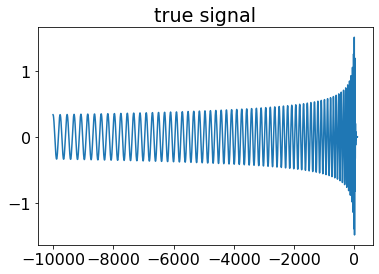

In [38]:
plt.figure()
plt.plot(true_ts_times, true_ts_hp)
plt.title("true signal")

In [92]:
q_1d = np.linspace(1, 4, 20)
chi1z_1d = np.linspace(-1,1, 20)
chi2z_1d = np.linspace(-1,1, 20)
qq, cc1z, cc2z = np.meshgrid(q_1d, chi1z_1d, chi2z_1d)
qq = qq.ravel()
cc1z = cc1z.ravel()
cc2z = cc2z.ravel()
print(f"{len(qq)} waveforms")

8000 waveforms


In [66]:
from mpl_toolkits.mplot3d import Axes3D

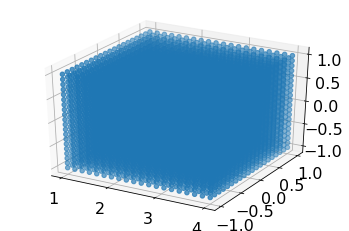

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(qq, cc1z, cc2z)

In [68]:
print("running the search")
t1 = time.time()
sur_hp, sur_hc, samp, sphase, sur_times = wave_sur_many(qq, cc1z, cc2z, amp_model, amp_basis, phase_model, phase_basis, true_ts_times)
t2 = time.time()
dt = t2-t1
print(f"generated {len(qq)} waveforms took: {dt:.2f}s")
print(f"time per waveform: {dt/len(qq):.5f} s")

# serial match version
# print("running matches")
# matches = []
# for i in tqdm.tqdm(range(len(qq))):
#     maxmatch = np.max(np.abs(match(true_ts_hp, sur_hp[i], true_ts_times)))
#     matches.append(maxmatch)
# matches = np.array(matches)
# max_match_idx = matches.argmax()
# max_params = dict(q=qq[max_match_idx], chi=cc[max_match_idx])
# print("max params:")

# print(f"q = {max_params['q']}, chi = {max_params['chi']}")

running the search
generated 8000 waveforms took: 55.86s
time per waveform: 0.00698 s


In [69]:
#parallel match version

n_cores = 20
tasks = list(sur_hp)

# here a task is a surrogate waveform - it is faster to parallelise this rather than mapping over the index of the array
# probably because there is a lot of overhead to pass the data
def worker_match(task, data, times):
    maxmatch = np.max(np.abs(match(data, task, times)))
    return maxmatch

worker_match_partial = functools.partial(worker_match, data=true_ts_hp, times=true_ts_times)

print("running matches")
print(f"using {n_cores} cores")

t1 = time.time()
if n_cores == 1:
    pool = gen_wf_data.SinglePool()
else:
    pool = schwimmbad.choose_pool(mpi=False, processes=n_cores)
matches = pool.map(worker_match_partial, tasks)
try:
    pool.close
except AttributeError:
    pass
t2 = time.time()
dt = t2-t1
print(f"computed matches in: {dt:.2f}s")

matches = np.array(matches)
max_match_idx = matches.argmax()
max_params = dict(q=qq[max_match_idx], chi1z=cc1z[max_match_idx], chi2z=cc2z[max_match_idx])
print("max params:")
print(f"q = {max_params['q']}, chi1z = {max_params['chi1z']}, chi2z = {max_params['chi2z']}")

running matches
using 20 cores
computed matches in: 19.36s
max params:
q = 3.052631578947368, chi1z = 0.4736842105263157, chi2z = -1.0


In [70]:
print(f"max match: {matches[max_match_idx]}")

max match: 0.9966272339026825


In [71]:
q_bias = max_params['q'] - q_true
chi1z_bias = max_params['chi1z'] - chi1z_true
chi2z_bias = max_params['chi2z'] - chi2z_true

In [72]:
print(f"\Delta q = {q_bias[0]}")
print(f"\Delta chi1z = {chi1z_bias[0]}")
print(f"\Delta chi2z = {chi2z_bias[0]}")

\Delta q = 0.05263157894736814
\Delta chi1z = 0.12868421052631573
\Delta chi2z = -0.655


Text(0.5, 0.98, 'match')

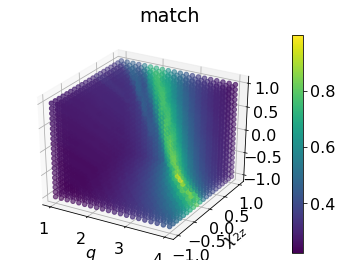

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(qq, cc1z, cc2z, c=matches)
fig.colorbar(p)
ax.scatter(qq[max_match_idx], cc1z[max_match_idx], cc2z[max_match_idx], s=200, lw=2, marker='x', c='r')
ax.scatter(q_true, chi1z_true, chi2z_true, s=200, lw=2, marker='+', c='k')
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$\chi_{1z}$')
ax.set_ylabel(r'$\chi_{2z}$')
fig.suptitle("match")

Text(0.5, 1.0, 'match')

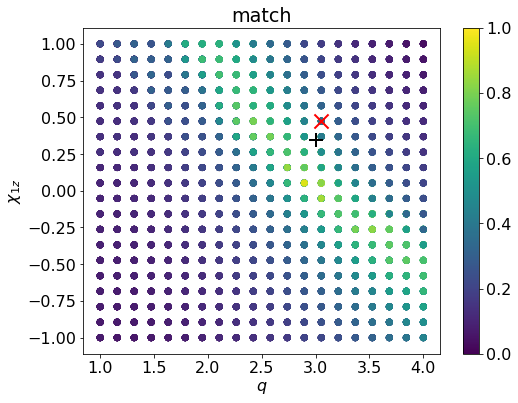

In [75]:
plt.figure(figsize=(8,6))
plt.scatter(qq, cc1z, c=matches)
plt.scatter(qq[max_match_idx], cc1z[max_match_idx], s=200, lw=2, marker='x', c='r')
plt.scatter(q_true, chi1z_true, s=200, lw=2, marker='+', c='k')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_{1z}$')
plt.title("match")

Text(0.5, 1.0, 'match')

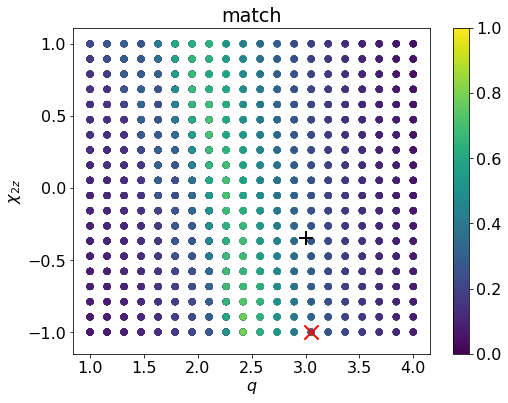

In [76]:
plt.figure(figsize=(8,6))
plt.scatter(qq, cc2z, c=matches)
plt.scatter(qq[max_match_idx], cc2z[max_match_idx], s=200, lw=2, marker='x', c='r')
plt.scatter(q_true, chi2z_true, s=200, lw=2, marker='+', c='k')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_{2z}$')
plt.title("match")

In [77]:
true_sur_hp, true_sur_hc, true_samp, true_sphase, true_sur_times = wave_sur_many(q_true, chi1z_true, chi2z_true, amp_model, amp_basis, phase_model, phase_basis, true_ts_times)

In [78]:
print("best the model can really do:")
np.max(np.abs(match(true_ts_hp, true_sur_hp[0], true_ts_times)))

best the model can really do:


0.9999496994602167

(-100, 100)

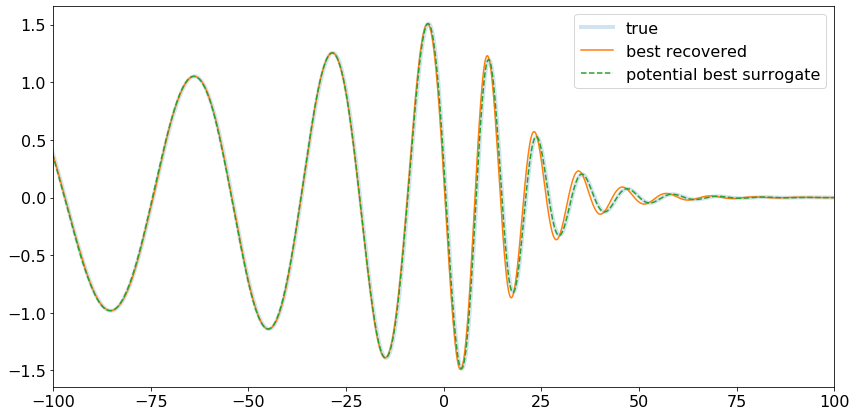

In [79]:
plt.figure(figsize=(14, 7))
plt.plot(true_ts_times, true_ts_hp, label='true', lw=4, alpha=0.2)
plt.plot(true_ts_times, sur_hp[max_match_idx], label='best recovered')
plt.plot(true_ts_times, true_sur_hp[0], label='potential best surrogate', ls='--')

plt.legend()
plt.xlim(-100,100)

# overhead cost

In [100]:
max_nn = 1000

nns=[]
dt_per=[]

print("generating waveforms")

for nn in range(1, max_nn, 100):
    print(nn)
    nns.append(nn)
    t1 = time.time()
    sur_hp, sur_hc, samp, sphase, sur_times = wave_sur_many(qq[:nn], cc1z[:nn], cc2z[:nn], amp_model, amp_basis, phase_model, phase_basis, true_ts_times)
    t2 = time.time()
    dt = t2-t1

    print(f"generated {nn} waveforms took: {dt:.2f}s")
    print(f"time per waveform: {dt/nn:.5f} s")

    dt_per.append(dt/nn)

generating waveforms
1
generated 1 waveforms took: 1.08s
time per waveform: 1.07771 s
101
generated 101 waveforms took: 1.78s
time per waveform: 0.01758 s
201
generated 201 waveforms took: 2.50s
time per waveform: 0.01243 s
301
generated 301 waveforms took: 3.28s
time per waveform: 0.01088 s
401
generated 401 waveforms took: 3.80s
time per waveform: 0.00947 s
501
generated 501 waveforms took: 4.52s
time per waveform: 0.00903 s
601
generated 601 waveforms took: 5.29s
time per waveform: 0.00880 s
701
generated 701 waveforms took: 6.11s
time per waveform: 0.00871 s
801
generated 801 waveforms took: 6.96s
time per waveform: 0.00869 s
901
generated 901 waveforms took: 7.89s
time per waveform: 0.00876 s


In [104]:
dt_per

[1.0777060985565186,
 0.017575334794450514,
 0.012427367974276566,
 0.010882118611636748,
 0.009470666138608556,
 0.009028948709636391,
 0.008801077844299215,
 0.00871486534575763,
 0.008694083205471919,
 0.00876187748967212]

(0.001, 11.220184543019636)

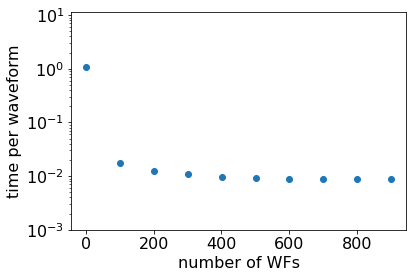

In [106]:
plt.figure()
plt.scatter(nns, dt_per)
plt.xlabel('number of WFs')
plt.ylabel('time per waveform')
plt.yscale('log')
plt.ylim(1e-3)

# try tf function from rhys but with the 1D model

In [135]:
import tensorflow as tf

In [168]:
# rootdir = '/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline/test-run/run'
# rootdir = '/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline/test-run-3d/run'
rootdir = '/home/sebastian.khan/git/stk/scrinet/examples/surrogate'

In [169]:
# amp_basis = os.path.join(rootdir, 'rb/amp/amp_eim_basis.npy')
# amp_model_dir = os.path.join(rootdir, 'ts/amp/fits')

# phase_basis = os.path.join(rootdir, 'rb/phase/phase_eim_basis.npy')
# phase_model_dir = os.path.join(rootdir, 'ts/phase/fits')

amp_basis = os.path.join(rootdir, 'amp/amp_basis.npy')
amp_model_dir = os.path.join(rootdir, 'amp')

phase_basis = os.path.join(rootdir, 'phase/phase_basis.npy')
phase_model_dir = os.path.join(rootdir, 'phase')

In [170]:
amp_model, amp_basis = load_model(
    basis_file=amp_basis,
    nn_weights_file=os.path.join(amp_model_dir, "best.h5"),
    X_scalers_file=os.path.join(amp_model_dir, "X_scalers.npy"),
    Y_scalers_file=os.path.join(amp_model_dir, "Y_scalers.npy"))

phase_model, phase_basis = load_model(
    basis_file=phase_basis,
    nn_weights_file=os.path.join(phase_model_dir, "best.h5"),
    X_scalers_file=os.path.join(phase_model_dir, "X_scalers.npy"),
    Y_scalers_file=os.path.join(phase_model_dir, "Y_scalers.npy"))

In [203]:
def predict_no_tf(qs, amp_model=amp_model, amp_basis=amp_basis, phase_model=phase_model, phase_basis=phase_basis):
    
    times = np.linspace(-10000, 100, 5000)
    
    qs = np.array(qs)
    pars = qs.reshape(-1, 1)
    pars[:,0] = np.log(pars[:,0]) # need to log the mass-ratio

    amp_alpha = amp_model.predict(pars)
    amp = np.dot(amp_alpha, amp_basis)

    phase_alpha = phase_model.predict(pars)
    phase = np.dot(phase_alpha, phase_basis)

    h = amp * np.exp(-1.j * phase)

    return np.real(h), np.imag(h), amp, phase, times

In [171]:
@tf.function(experimental_compile = True, experimental_relax_shapes=True )
def predict_hack(model, _input):
    x = _input
    x = x_scale_hack(model, x)
    pred = x * tf.ones([len(x)], dtype = tf.float64)
    pred = tf.reshape(pred, shape = (-1,1))
    for layer in model.model.layers:
        pred = layer(pred)
    pred = tf.reshape(pred, shape = (-1, pred.shape[1],))
    pred = y_inv_scale_hack(model, pred)
    return pred

In [172]:
@tf.function(experimental_compile = True, experimental_relax_shapes=True )
def x_scale_hack(model, _input):
    x = _input
    mean = tf.constant(model.X_scalers[0].mean_)
    std = tf.constant(model.X_scalers[0].scale_)
    x_scaled = (x - mean)/std
    return x_scaled

In [173]:
@tf.function(experimental_compile = True, experimental_relax_shapes=True )
def get_model_y_std_scalers(model, _input):
    std = [model.Y_scalers[i].scale_[0] for i in range(len(model.Y_scalers))]
    std = tf.stack(std, axis=0)
    std = tf.cast(std, tf.float32)
    return std

@tf.function(experimental_compile = True, experimental_relax_shapes=True )
def get_model_y_mean_scalers(model, _input):
    mean = [model.Y_scalers[i].mean_[0] for i in range(len(model.Y_scalers,))]
    mean = tf.stack(mean, axis=0)
    mean = tf.cast(mean, tf.float32)
    return mean

In [174]:
@tf.function(experimental_compile = True, experimental_relax_shapes=True )
def y_inv_scale_hack(model, _input):
    y_scaled = _input
    y_scaled = tf.reshape(y_scaled , shape = (len(_input), -1))

    mean = get_model_y_mean_scalers(model, _input)

    std = get_model_y_std_scalers(model, _input)
    y = y_scaled*std + mean
    return y

In [175]:
@tf.function(experimental_compile = True, experimental_relax_shapes=True )
def generate_surrogate(q,
                  amp_basis=amp_basis,
                  phase_basis=phase_basis ):
    
    q = tf.cast(q, tf.float64)
    q = tf.reshape(q, shape = (len(q),))
    q = tf.math.log(q)
    
    q = tf.convert_to_tensor(q, dtype = tf.float64)

    amp_alpha = predict_hack(amp_model, q)

    amp_alpha = tf.cast(amp_alpha, tf.float64)
    amp_basis = tf.cast(amp_basis, tf.float64)
    
    amp = tf.tensordot(amp_alpha, amp_basis, axes=1)

    phase_alpha = predict_hack(phase_model, q)
    
    phase_alpha = tf.cast(phase_alpha, tf.float32)
    phase_basis = tf.cast(phase_basis, tf.float32)
    
    phase = tf.tensordot(phase_alpha, phase_basis, axes=1)
        
    phase = tf.cast(phase, tf.complex64)
    amp = tf.cast(amp, tf.complex64)
    
    h = amp * tf.math.exp(-1.j * phase)
    
    return tf.math.real(h), tf.math.imag(h), amp, phase

In [196]:
p0.numpy()

array([[2.422349 ],
       [2.4166346],
       [2.293737 ],
       [1.3019114],
       [2.0093403]], dtype=float32)

In [204]:
%%timeit
sur_hp_no_tf, sur_hc_no_tf, samp_no_tf, sphase_no_tf, times = predict_no_tf(p0.numpy())

48.3 ms ± 854 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [232]:
%%timeit
sur_hp_no_tf, sur_hc_no_tf, samp_no_tf, sphase_no_tf, times = predict_no_tf([1])

43 ms ± 981 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [176]:
p0 = tf.random.uniform(minval = 1., maxval = 5,
                                       shape = (5, 1))

In [181]:
p0

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[2.422349 ],
       [2.4166346],
       [2.293737 ],
       [1.3019114],
       [2.0093403]], dtype=float32)>

In [184]:
sur_hp, sur_hc, samp, sphase = generate_surrogate(p0) 

In [230]:
%%timeit
sur_hp, sur_hc, samp, sphase = generate_surrogate([1])

676 µs ± 29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [208]:
46.5e-3/860e-6

54.06976744186046

In [221]:
p1 = tf.random.uniform(minval = 1., maxval = 6,
                                       shape = (1000, 1))

In [222]:
%%timeit
sur_hp, sur_hc, samp, sphase = generate_surrogate(p1) 

45.3 ms ± 5.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [223]:
%%timeit
sur_hp_no_tf, sur_hc_no_tf, samp_no_tf, sphase_no_tf, times = predict_no_tf(p1.numpy())

776 ms ± 6.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [224]:
776/45

17.244444444444444